In [97]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize

# parameters that you should set before running this script
filter = ['cat', 'dog']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "/Users/ericmassip/Projects/MAI/2nd_semester/CV/Project/VOCdevkit/"  # please replace with the location on your laptop where you unpacked the tarball
image_size = 64    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

In [100]:
def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y

In [101]:
x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

582 training images from 2 classes
610 validation images from 2 classes


In [102]:
import matplotlib.pyplot as plt
import cv2

def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])

In [103]:
x_train_gray = convert_to_grayscale(x_train)
x_val_gray = convert_to_grayscale(x_val)

(64, 64)


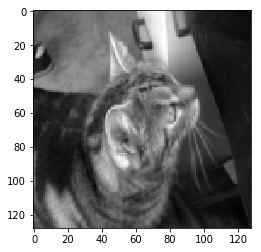

In [104]:
print(x_train_gray[0].shape)

plt.imshow(gray, cmap='gray')

## From here, you can start building your model you will only need x_train and x_val for the autoencoder you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)

# Autoencoder

In [143]:
import tensorflow as tf
import keras, keras.layers as L

img_shape = (image_size, image_size, 1)
#img_shape=(44, 44, 3)
H,W,C = img_shape
code_size = 1024
    
# encoder
encoder = keras.models.Sequential()
encoder.add(L.InputLayer(img_shape))
encoder.add(L.Conv2D(32, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Conv2D(16, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
encoder.add(L.MaxPool2D(pool_size=(2, 2)))
encoder.add(L.Flatten())
encoder.add(L.Dense(code_size))


# decoder
decoder = keras.models.Sequential()
decoder.add(L.InputLayer((code_size,)))
decoder.add(L.Dense(4096))
decoder.add(L.Reshape((16, 16, 16)))
decoder.add(L.Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=2, activation='elu', padding='same'))
decoder.add(L.Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

In [144]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_197 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 1024)              4195328   
Total params: 4,200,272
Trainable params: 4,200,272
Non-trainable params: 0
_________________________________________________________________


In [145]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 4096)              4198400   
_________________________________________________________________
reshape_28 (Reshape)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_transpose_64 (Conv2DT (None, 32, 32, 16)        1040      
_________________________________________________________________
conv2d_transpose_65 (Conv2DT (None, 64, 64, 1)         145       
Total params: 4,199,585
Trainable params: 4,199,585
Non-trainable params: 0
_________________________________________________________________


In [147]:
# I should've automatically calculated the shapes but I just prepared the code to handle 44, 44, 3 shaped image only
IMG_DIM = 64

# Let's load the dataset again
# Loading and normalizing
#X, attr = load_lfw_dataset(use_raw=True,dimx=IMG_DIM,dimy=IMG_DIM)
#X = X.astype('float32') / 255.0

#img_shape = X.shape[1:]

#X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

#encoder,decoder = build_deep_conv_autoencoder((IMG_DIM, IMG_DIM, 3),code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder.fit(x=x_train_gray,y=x_train_gray,epochs=1,
                validation_data=[x_val_gray,x_val_gray])

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')
autoencoder.fit(x=x_train_gray,y=x_train_gray,epochs=1,
                validation_data=[x_val_gray,x_val_gray])

ValueError: Error when checking input: expected input_20 to have 4 dimensions, but got array with shape (582, 64, 64)